# Question 1: How do Airbnb rates differ across listings from Berlin?
The first question around the Airbnb Berlin data set is about the differences of rates per night and person for Airbnb homes in the city. The steps involved in answering the question are as follows:
* Load Libraries
* Import Data Set
* Pre-Processing
* Analyze Data Set & Evaluate Results

## Load Libraries

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Import Data Set

In [121]:
# Import listings data
df_listings = pd.read_csv('/Users/patrick.peltier/Documents/Udacity Data Science Nanodegree/Data/Airbnb/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


## Pre-Processing

First of all, I am going to pre-process the data for the analysis as especially __columns including price information are encoded es objects__. In addition to this I introduce an __adjusted price variable__ as the current variable "price" doesn't consider cleaning fees or rates for additional guest. However, even though Berlin Airbnb homes can accommodate multiple guests most of the time, they only include one in their price. Before creating the new metric I have to __remove rows where the number of guests included is greater than the number of guest that can be accommodated__. I assume that these records contain false information.

In [122]:
# Check distriutions of property types
df_listings["property_type"].value_counts().sort_values(ascending=False).head()

Apartment             20317
Condominium             603
Loft                    423
House                   409
Serviced apartment      191
Name: property_type, dtype: int64

In [123]:
# Keep only apartments in analysis
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


In [124]:
# Adjust values of "neighbourhood_group_cleansed" (needs to be in correct form for later use)
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

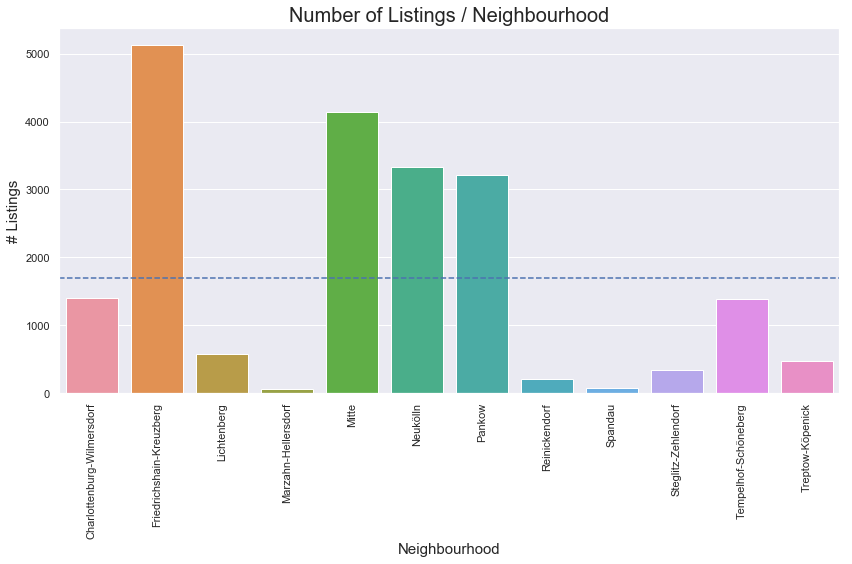

In [150]:
# Number of listings / neighbourhood
listings_neighbourhood = df_listings[["neighbourhood_group_cleansed","id"]]
listings_neighbourhood = listings_neighbourhood.groupby("neighbourhood_group_cleansed", as_index=False).agg("count")
listings_neighbourhood.columns = ["neighbourhood_group", "num_listings"]

# Plot
plt.subplots(figsize=(12,8))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group", y="num_listings", data=listings_neighbourhood)
plt.xticks(rotation=90);
plt.title("Number of Listings / Neighbourhood", fontsize=20)
plt.ylabel("# Listings", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add median as reference line
ax.axhline(listings_neighbourhood["num_listings"].mean(), ls='--');

In [126]:
# Column "reviews_per_month" can only be used as proxy for booking frequency if
# it doesn't exceed to the maximum monthly availability of each listing

# Fill missing values with 0
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

df_listings["bookings_per_month"].describe()

count    20317.000000
mean         0.885989
std          1.337913
min          0.000000
25%          0.060000
50%          0.330000
75%          1.080000
max         14.790000
Name: bookings_per_month, dtype: float64

In [127]:
# Calculate the monthly occupancy rate for each listing
df_listings["occupancy_rate"] = (df_listings["bookings_per_month"] * df_listings["minimum_nights"] / 30.42).fillna(0)
df_listings["occupancy_rate"].describe()

count    20317.000000
mean         0.091688
std          0.160096
min          0.000000
25%          0.005260
50%          0.032873
75%          0.106509
max          1.000000
Name: occupancy_rate, dtype: float64

In [128]:
# Create data frame with area in square kilometre of neighbourhood groups
# Source: https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins
hood_names = ['Pankow','Tempelhof-Schöneberg','Friedrichshain-Kreuzberg','Neukölln','Mitte','Charlottenburg-Wilmersdorf',
              'Treptow-Köpenick','Lichtenberg','Reinickendorf','Steglitz-Zehlendorf','Marzahn-Hellersdorf','Spandau']
hood_size = [103.01,53.09,20.16,44.93,39.47,103.01,168.42,52.29,89.46,102.50,61.74,91.91]
hood_area = pd.DataFrame({"neighbourhood_group": hood_names, "area_km2": hood_size})
hood_area = hood_area.sort_values("neighbourhood_group").reset_index(drop=True)
hood_area.head()

,neighbourhood_group,area_km2
0,Charlottenburg-Wilmersdorf,103.01
1,Friedrichshain-Kreuzberg,20.16
2,Lichtenberg,52.29
3,Marzahn-Hellersdorf,61.74
4,Mitte,39.47


In [131]:
# Create data frame with occupancy rate and listing density for each neighbourhood
# Grouping functions
f = {"id":["count"], "occupancy_rate":["mean"], "review_scores_rating":["mean"]}

# Grouping data
hood_popularity = df_listings[["neighbourhood_group_cleansed","id","occupancy_rate","review_scores_rating"]]
hood_popularity = hood_popularity.groupby("neighbourhood_group_cleansed", as_index=False).agg(f)
hood_popularity.columns = ["neighbourhood_group", "num_listings", "occupancy_rate","review_scores_rating"]
hood_popularity = hood_popularity.sort_values("neighbourhood_group")

# Calculate density
hood_popularity["area_km2"] = hood_area["area_km2"]
hood_popularity["listings_per_km2"] = hood_popularity["num_listings"] / hood_popularity["area_km2"]

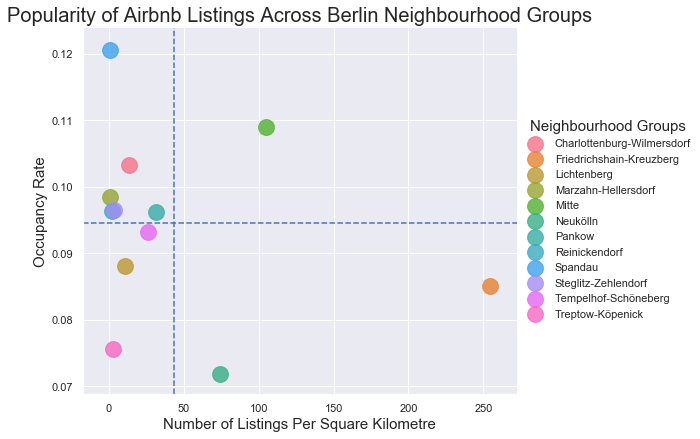

In [148]:
# Plot occupancy vs. listings per square kilometre
# Plot
sns.set(style="darkgrid")
p = sns.lmplot("listings_per_km2", "occupancy_rate", data=hood_popularity,
               hue="neighbourhood_group", fit_reg=False,
               height=6, aspect=1.2, scatter_kws={"s": 250})

# Add median as reference line
plt.axhline(hood_popularity["occupancy_rate"].mean(), ls='--');
plt.axvline(hood_popularity["listings_per_km2"].mean(), ls='--');

# Set labels
plt.title("Popularity of Airbnb Listings Across Berlin Neighbourhood Groups", fontsize=20)
plt.ylabel("Occupancy Rate", fontsize=15)
plt.xlabel("Number of Listings Per Square Kilometre", fontsize=15)
p._legend.set_title("Neighbourhood Groups")
plt.setp(p._legend.get_title(), fontsize=15);

## Analyses